# <img src="https://img.icons8.com/fluency/96/000000/particles.png" style="height:50px;display:inline"> Deep Latent Particles - Tutorial
---

Tal Daniel



<center>
    <a href="https://colab.research.google.com/github/taldatech/deep-latent-particles-pytorch/blob/main/dlp_tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</center>

* Paper: [**Unsupervised Image Representation Learning with Deep Latent Particles**, Tal Daniel and Aviv Tamar, ICML 2022](https://arxiv.org/)
* GitHub: <a href="https://github.com/taldatech/deep-latent-particles-pytorch">deep-latent-particles-pytorch</a>
* Wepage: <a href="https://taldatech.github.io/deep-latent-particles-web/">ICML 2022 - Deep Latent Particles</a>

<img src="https://raw.githubusercontent.com/taldatech/deep-latent-particles-web/main/assets/clevrer_manip_1.gif" style="height:250px">

### <img src="https://img.icons8.com/color/96/000000/loading.png" style="height:50px;display:inline"> Running Instructions
---
* This Jupyter Notebook can be opened locally with Anaconda, or online via Google Colab.
* To run online, go to https://colab.research.google.com/ and drag-and-drop the `dlp_tutorial.ipynb` file.
    * On Colab, note the "directory" icon on the left, logs, figures and checkpoints are saved in this directory.
* To run the training on the image dataset, it is better to have a GPU. In Google Cola select `Runtime->Change runtime type->GPU`.

### <img src="https://img.icons8.com/color/96/000000/software-installer.png" style="height:50px;display:inline"> Requirements
---
* If running locally, make sure to set up the environment, preferably with <a href="https://anaconda.org/">Anaconda</a> by running `conda env create -f environment17/19.yml` or with `pip` by running `pip install - r requirements17/19.txt`.
* If running online on <a href="https://colab.research.google.com">Google Colab</a>, run the following cell to clone the repository.

In [1]:
# only run this cell if running on Google Colab
!git clone https://github.com/taldatech/deep-latent-particles-pytorch.git
!cd deep-latent-particles-pytorch
!pip install -r requirements19.txt

Cloning into 'deep-latent-particles-pytorch'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 155 (delta 67), reused 127 (delta 43), pack-reused 0
Receiving objects: 100% (155/155), 18.21 MiB | 9.09 MiB/s, done.
Resolving deltas: 100% (67/67), done.


### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Introduction](#-Introduction)
* [Random Shapes Dataset](#-Random-Shapes-Dataset)
* [The Model](#-The-Model)
* [Training and Optimization](#-Training-and-Optimization)
* [Visualization and Manipulation](#Visualization-and-Manipulation)
* [Where to Next?](#--Where-to-Next?)
* [Credits](#-Credits)

In [7]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
# torch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch.optim as optim
# model
from models import KeyPointVAE
# util functions
# from utils.util_func import reparameterize, get_kp_mask_from_gmap, create_masks_fast,
#plot_keypoints_on_image_batch, create_masks_fast, prepare_logdir, save_config, log_line,\
#     plot_bb_on_image_batch_from_masks_nms
from utils.util_func import *
from utils.loss_functions import ChamferLossKL, calc_kl, calc_reconstruction_loss, VGGDistance
# datasets
from datasets.shapes_ds import generate_shape_dataset_torch

### <img src="https://img.icons8.com/bubbles/50/000000/mention.png" style="height:50px;display:inline"> Introduction
---
* In this tutorial, we will give a brief overview of the deep latent particles (DLP) framework. 
* DLP is a new representation of visual data that disentangles object position from appearance. 
* DLP decomposes the visual input into low-dimensional latent ``particles'', where each particle is described by its spatial location ($z_p$) and features ($z_{\alpha}$) of its surrounding region. $$ \{(z_p^i, z_{\alpha}^i) \}_{i=1}^K $$
* DLP is trained with a variational autoencoder (VAE) objective with a special prior for particle positions based on a spatial-softmax architecture, and a modification of the evidence lower bound (ELBO) loss inspired by the Chamfer distance between particles.
* DLP comes in two flavors depending on the scene type: **(1) Masked model** and **(2) Object-based model**.
* **Masked model**: designed for non-object scenes (e.g., faces from CelebA), PointNet++ and Gaussian maps model the local regions around the particles, and the rest (e.g., the background) is propagated from the encdoer ($\Phi_{bypass}$). 
* **Object-based model**: designed for object-based scenes (e.g., CLEVRER), PointNet++ models the global regions (e.g., the background) and Gaussian maps (optionally) and a separate Glimpse decoder model the objects and their masks.
* In this tutorial, *we will focus on the object-based model*.

### <img src="https://img.icons8.com/external-icongeek26-linear-colour-icongeek26/64/000000/external-shapes-graphic-design-icongeek26-linear-colour-icongeek26.png" style="height:50px;display:inline"> Random Shapes Dataset
---
* First, we will take a look at data for the tutorial: images of random shapes of different sizes and colors.

  0%|          | 0/5 [00:00<?, ?it/s]

sample_images: <torch.utils.data.dataset.TensorDataset object at 0x00000190288A3F88>


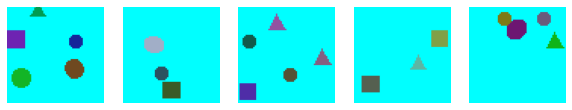

In [7]:
sample_images = generate_shape_dataset_torch(img_size=64, num_images=5)  # [5, 3, 64, 64]
print(f'sample_images: {sample_images}')
# plot
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    ax = fig.add_subplot(1, len(sample_images), i + 1)
    ax.imshow(sample_images[i][0].permute(1, 2, 0).data.cpu())
    ax.set_axis_off()

### <img src="https://img.icons8.com/external-flaticons-flat-flat-icons/64/000000/external-neural-network-the-future-flaticons-flat-flat-icons.png" style="height:50px;display:inline"> The Model
---
* The model has 3 main components: encoder network, prior network, and decoder network(s).

#### Encoder
---
<img src="https://raw.githubusercontent.com/taldatech/deep-latent-particles-web/main/assets/dlp_encoder.gif" style="height:250px">

The encoder is composed of two components:
1. **Position encoder**: outputs keypoints -- the spatial location $z_p = (x,y)$ of interesting areas, where $(x,y)$ are the coordinates of pixels.
2. **Appearance encoder**: extracts patches (or glimpses) of pre-determined size centered around $z_p$ and encodes them to latent variables $z_{\alpha}$.

In [ ]:
# PSEUDOCODE - DO NOT RUN
# posterior
enc_out = self.encode(x, return_heatmap=True, mask=mask)  # position encoder
mu, logvar, kp_heatmap, mu_features, logvar_features, obj_on, _ = enc_out
# obj_on is a transperency/presence variable, valeus between [0, 1]
# kp_heatmap is a low dimension featuer map, output of the cnn - used to extract visual features later
# mu/logvar_features = None [placeholders]
# sample
z = reparameterize(mu, logvar)
# convert [x, y] to gaussian maps (gmaps) -- will be used in the decoder
gmap_1_fg = self.to_gauss_map(z[:, :-1], self.features_dim, self.features_dim)
# convert gmaps to binary mask -- to cover up parts of the visual feature maps
fg_masks_sep = get_kp_mask_from_gmap(gmap_1_fg, threshold=self.mask_threshold,
                                     binary=True, elementwise=True).detach()
fg_masks = fg_masks_sep.sum(1, keepdim=True).clamp(0, 1)
bg_masks = 1 - fg_masks
masks_sep = torch.cat([fg_masks_sep, bg_masks], dim=1)
# extract visual features around the particles
feat_source = x if self.use_object_dec else kp_heatmap.detach()
# feat_source is the source from which we extract regions (x is the original image)
obj_enc_out = self.encode_object_features_sep(feat_source, z[:, :-1], kp_heatmap.detach(), masks_sep.detach())
mu_features, logvar_features, cropped_objects = obj_enc_out[0], obj_enc_out[1], obj_enc_out[2]
# note that the last particle is reserved for the bg and is located at (0, 0) [the center of the image]
# this is why we use z[:, :-1] when we extract features for the particles

#### Prior
---
* The prior addresses the question: what are the interesting areas in the image?
* It constrains the model such that the output of the position encoder is actually spatial positions and not just random values between $[-1, 1]$.
* We extract points-of-intereset in the image by applying spatial-Softmax (SSM) over feature maps extracted from **patches** in the image. 
* We term the set of extracted prior keypoints as keypoint proposals.
* Since we output one keypoint per patch, we may end up with a large set of keypoints, not all are informative.
* To filter out some proposal keypoints, we either randomly sample from this set or use a heuristic where we take the top-K most distant keypoints from the center of the patch.
* The reasoning behind the heuristic is that SSM is based on averaging, and contant areas in the image (e.g., a solid color patch) are not informative and SSM will result in a keypoint in the center of the patch.

In [ ]:
# PSEUDOCODE - DO NOT RUN
# prior
kp_p = self.prior(x_prior, global_kp=True)  
# global_kp = True returns the coordinates in the whole image. 
# Otherwise, returns the local coordinates inside the patch.
kp_p = kp_p.view(x_prior.shape[0], -1, 2)  # [batch_size, n_kp_total, 2]
# filter proposals by distance to the patches' center
dist_from_center = self.prior.get_distance_from_patch_centers(kp_p, global_kp=True)
_, indices = torch.topk(dist_from_center, k=self.n_kp_prior, dim=-1, largest=True)
batch_indices = torch.arange(kp_p.shape[0]).view(-1, 1).to(kp_p.device)
kp_p = kp_p[batch_indices, indices]
# random cnn features for prior also work
kp_p = kp_p.detach()
# alternatively, just sample random kp
# kp_p = kp_p[:, torch.randperm(kp_p.shape[1])[:self.n_kp_prior]]

#### Decoder
---
<img src="https://raw.githubusercontent.com/taldatech/deep-latent-particles-web/main/assets/dlp_decoder.gif" style="height:250px">

In the decoder for the **object-based** model PointNet++ models the global regions (e.g., the background) and Gaussian maps (optionally) and a separate Glimpse decoder model the objects and their masks.

In [ ]:
# PSEUDOCODE - DO NOT RUN
# decoder
gmap_1_fg = self.to_gauss_map(z[:, :-1], self.features_dim, self.features_dim)
gmap_1_bg = 1 - gmap_1_fg.sum(1, keepdim=True).clamp(0, 1).detach()
gmap_1 = torch.cat([gmap_1_fg, gmap_1_bg], dim=1)
fg_masks_sep = get_kp_mask_from_gmap(gmap_1_fg, threshold=self.mask_threshold,
                                     binary=True, elementwise=True).detach()
fg_masks = fg_masks_sep.sum(1, keepdim=True).clamp(0, 1)
bg_masks = 1 - fg_masks
masks = torch.cat([fg_masks.expand_as(gmap_1_fg), bg_masks], dim=1)
gmap_2 = self.pointnet(position=z.detach(), features=torch.cat([z.detach(), z_features], dim=-1))
gmap = torch.cat([gmap_1[:, :-1], gmap_2], dim=1)
rec = self.dec(gmap)  # bg elements
# decode object and translate them to the positions of the keypoints
object_dec_out = self.decode_objects(z, z_features, obj_on, bg=rec)
dec_objects, dec_objects_trans, rec = object_dec_out

#### Putting it All Together
---
<img src="https://raw.githubusercontent.com/taldatech/deep-latent-particles-web/main/assets/dlp_arch_all.PNG" style="height:400px">

###  <img src="https://img.icons8.com/external-icongeek26-linear-colour-icongeek26/64/000000/external-shapes-graphic-design-icongeek26-linear-colour-icongeek26.png" style="height:50px;display:inline"> Training and Optimization
---
The model is optimized as a variational autoencoder (VAE) with objective of maximizing the evidence lower bound (ELBO): $$ \log p_\theta(x) \geq \mathbb{E}_{q(z|x)} \left[\log p_\theta(x|z)\right] - KL(q(z|x) \Vert p(z)) \doteq ELBO(x) $$
The ELBO is decomposed to the <i>reconstruction error</i> and a <i>KL-divergence</i> regularization term.

However, here we have two **unordered sets** (or point clouds) of position latent variables: the posterior keypoints and the keypoint proposals from the prior. Note that *the number of points in each set may also differ*.


The Chamfer distance between two sets $S_1$ and $S_2$: 
$$ d_{CH}(S_1, S_2) = \sum_{x \in S_1}\min_{y \in S_2}||x-y||_2^2 + \sum_{y \in S_2}\min_{x \in S_1}||x-y||_2^2. $$
<img src="https://raw.githubusercontent.com/taldatech/deep-latent-particles-web/main/assets/chamfer_distance.gif" style="height:300px">

Animation by <a href="https://www.youtube.com/watch?v=P4IyrsWicfs">Luke Hawkes</a>.

We propose the <b>Chamfer-KL</b>, a <i>novel modification</i> for the KL term:
$$ d_{CH-KL}(S_1, S_2) = \sum_{x \in S_1}\min_{y \in S_2}KL(x \Vert y) + \sum_{y \in S_2}\min_{x \in S_1}KL(x \Vert y). $$
Note that the Chamfer-KL is not a metric and maintains the properties of the standard KL term.

The complete training objective follows the $\beta$-VAE formulation: $$ \mathcal{L} =  \mathcal{L}_{rec}(x, \tilde{x}) +\beta_{CKL}CH-KL(q_{\phi}(z_p|x)\Vert p_{\psi}(z|x)) + \beta_{KL} KL(q_{\phi}(z_a|x) \Vert p(z)).$$ We found it crucial to balance the two KL terms, where usually $\beta_{CKL} > \beta_{KL}$.

#### Hyper-parameters
---
DLP has some trivial hyper-parameters just like any other model (e.g., learning rate, batch size and etc...), and the rest are described below:

* `ds`: dataset name (str)
* `enc_channels`: channels for the posterior CNN (takes in the whole image)
* `prior_channels`: channels for prior CNN (takes in patches)
* `n_kp`: number of kp to extract from each (!) patch
* `n_kp_prior`: number of kp to filter from the set of prior kp (of size n_kp x num_patches)
* `n_kp_enc`: number of posterior kp to be learned (this is the actual number of kp that will be learnt)
* `use_logsoftmax`: for spatial-softmax, set True to use log-softmax for numerical stability
* `pad_mode`: padding for the CNNs, 'zeros' or  'replicate' (default)
* `sigma`: the prior std of the KP
* `dropout`: dropout for the CNNs. We don't use it though...
* `dec_bone`: decoder backbone -- "gauss_pointnetpp_feat": Masked Model, "gauss_pointnetpp": Object Model
* `patch_size`: patch size for the prior KP proposals network (not to be confused with the glimpse size)
* `kp_range`: the range of keypoints, can be $[-1, 1]$ (default) or $[0,1]$
* `learned_feature_dim`: the latent visual features dimensions extracted from glimpses.
* `kp_activation`: the type of activation to apply on the keypoints: "tanh" for kp_range $[-1, 1]$, "sigmoid" for $[0, 1]$
* `mask_threshold`: activation threshold (>thresh -> 1, else 0) for the binary mask created from the Gaussian-maps.
* `anchor_s`: defines the glimpse size as a ratio of image_size (e.g., 0.25 for image_size=128 -> glimpse_size=32)
* `learn_order`: experimental feature to learn the order of keypoints - but it doesn't work yet.
* `use_object_enc`: set True to use a separate encoder to encode visual features of glimpses.
* `use_object_dec`: set True to use a separate decoder to decode glimpses (Object Model).
* `iou_thresh`: intersection-over-union threshold for non-maximal suppression (nms) to filter bounding boxes
* `use_tps`: set True to use a tps augmentation on the input image for datasets that support this option
* `use_pairs`: for CelebA dataset, set True to use a tps-augmented image for the prior.
* `topk`: the number top-k particles with the lowest variance (highest confidence) to filter for the plots.
* `warmup_epoch`: (used for the Object Model) number of epochs where only the object decoder is trained.
* `recon_loss_type`: tpe of pixel reconstruction loss ("mse", "vgg").
* `beta_rec`: coefficient for the reconstruction loss (we use 1.0).
* `beta_kl`: coefficient for the KL divergence term in the loss.
* `kl_balance`: coefficient for the balance between the ChamferKL (for the KP) and the standard KL (for the visual features), kl_loss = beta_kl * (chamfer_kl + kl_balance * kl_features)
* `exclusive_patches`: (mostly) enforce one particle pre object by masking up regions that were already encoded.

In [5]:
# training
# default hyper-parameters
lr = 1e-3
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 100
load_model = False
eval_epoch_freq = 2
n_kp = 1  # num kp per patch
mask_threshold = 0.2  # mask threshold for the features from the encoder
kp_range = (-1, 1)
weight_decay = 0.0
run_prefix = ""
learn_order = False
use_logsoftmax = False
pad_mode = 'replicate'
sigma = 0.1  # default sigma for the gaussian maps
dropout = 0.0
kp_activation = "tanh"
iou_thresh = 0.2
# ds specific hp
ds = "shapes"
beta_kl = 0.05
beta_rec = 1.0
n_kp_enc = 10  # total kp to output from the encoder / filter from prior
n_kp_prior = 15
patch_size = 8
learned_feature_dim = 6  # additional features than x,y for each kp
dec_bone = "gauss_pointnetpp"  # object model
topk = min(10, n_kp_enc)  # display top-10 kp with smallest variance
recon_loss_type = "mse"
use_tps = False
use_pairs = False
use_object_enc = True  # separate object encoder
use_object_dec = True  # separate object decoder
warmup_epoch = 1
anchor_s = 0.25
kl_balance = 0.001
exclusive_patches = True

In [9]:
# load data
if ds == "shapes":
    image_size = 64
    ch = 3
    enc_channels = [32, 64, 128]
    prior_channels = (16, 32, 64)
    print('generating random shapes dataset')
    dataset = generate_shape_dataset_torch(num_images=40_000)
    milestones = (20, 40, 80)
else:
    raise NotImplementedError

# save hyper-parameters
hparams = {'ds': ds, 'batch_size': batch_size, 'lr': lr, 'kp_activation': kp_activation, 'pad_mode': pad_mode,
           'num_epochs': num_epochs, 'n_kp': n_kp, 'recon_loss_type': recon_loss_type,
           'use_logsoftmax': use_logsoftmax, 'sigma': sigma, 'beta_kl': beta_kl, 'beta_rec': beta_rec,
           'dec_bone': dec_bone, 'patch_size': patch_size, 'topk': topk, 'n_kp_enc': n_kp_enc,
           'eval_epoch_freq': eval_epoch_freq, 'learned_feature_dim': learned_feature_dim,
           'n_kp_prior': n_kp_prior, 'weight_decay': weight_decay, 'kp_range': kp_range,
           'run_prefix': run_prefix, 'mask_threshold': mask_threshold, 'use_tps': use_tps, 'use_pairs': use_pairs,
           'use_object_enc': use_object_enc, 'use_object_dec': use_object_dec, 'warmup_epoch': warmup_epoch,
           'iou_thresh': iou_thresh, 'anchor_s': anchor_s, 'learn_order': learn_order, 'kl_balance': kl_balance,
           'milestones': milestones, 'image_size': image_size, 'enc_channels': enc_channels,
           'prior_channels': prior_channels, 'exclusive_patches': exclusive_patches}

# create dataloader
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True,
                        drop_last=True)
# model
model = KeyPointVAE(cdim=ch, enc_channels=enc_channels, prior_channels=prior_channels,
                    image_size=image_size, n_kp=n_kp, learned_feature_dim=learned_feature_dim,
                    use_logsoftmax=use_logsoftmax, pad_mode=pad_mode, sigma=sigma,
                    dropout=dropout, dec_bone=dec_bone, patch_size=patch_size, n_kp_enc=n_kp_enc,
                    n_kp_prior=n_kp_prior, kp_range=kp_range, kp_activation=kp_activation,
                    mask_threshold=mask_threshold, use_object_enc=use_object_enc,
                    exclusive_patches=exclusive_patches, use_object_dec=use_object_dec, anchor_s=anchor_s,
                    learn_order=learn_order).to(device)

logvar_p = torch.log(torch.tensor(sigma ** 2)).to(device)  # logvar of the constant std -> for the kl
# prepare saving location
run_name = f'{ds}_dlp_{dec_bone}' + run_prefix
log_dir = prepare_logdir(runname=run_name, src_dir='./')
fig_dir = os.path.join(log_dir, 'figures')
save_dir = os.path.join(log_dir, 'saves')
save_config(log_dir, hparams)

kl_loss_func = ChamferLossKL(use_reverse_kl=False)
if recon_loss_type == "vgg":
    recon_loss_func = VGGDistance(device=device)
else:
    recon_loss_func = calc_reconstruction_loss
betas = (0.9, 0.999)
eps = 1e-4
# we use separate optimizers for the encoder and decoder, but it is not really necessary...
optimizer_e = optim.Adam(model.get_parameters(encoder=True, prior=True, decoder=False), lr=lr, betas=betas, eps=eps,
                         weight_decay=weight_decay)
optimizer_d = optim.Adam(model.get_parameters(encoder=False, prior=False, decoder=True), lr=lr, betas=betas,
                         eps=eps, weight_decay=weight_decay)

scheduler_e = optim.lr_scheduler.MultiStepLR(optimizer_e, milestones=milestones, gamma=0.5)
scheduler_d = optim.lr_scheduler.MultiStepLR(optimizer_d, milestones=milestones, gamma=0.5)

if load_model:
    try:
        model.load_state_dict(
            torch.load(os.path.join(save_dir, f'{ds}_dlp_{dec_bone}.pth'), map_location=device))
        print("loaded model from checkpoint")
    except:
        print("model checkpoint not found")

# statistics
losses = []
losses_rec = []
losses_kl = []
losses_kl_kp = []
losses_kl_feat = []

# save PSNR values of the reconstruction
psnrs = []

for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    batch_losses_rec = []
    batch_losses_kl = []
    batch_losses_kl_kp = []
    batch_losses_kl_feat = []
    batch_psnrs = []
    pbar = tqdm(iterable=dataloader)
    for batch in pbar:
        if ds == 'shapes':
            x = batch[0].to(device)
            x_prior = x
        else:
            x = batch.to(device)
            x_prior = x
        batch_size = x.shape[0]
        # forward pass
        noisy_masks = (epoch < 5 * warmup_epoch)  # add small noise to the alpha masks
        model_output = model(x, x_prior=x_prior, warmup=(epoch < warmup_epoch), noisy_masks=noisy_masks)
        mu_p = model_output['kp_p']
        gmap = model_output['gmap']
        mu = model_output['mu']
        logvar = model_output['logvar']
        rec_x = model_output['rec']
        mu_features = model_output['mu_features']
        logvar_features = model_output['logvar_features']
        # object stuff
        dec_objects_original = model_output['dec_objects_original']
        cropped_objects_original = model_output['cropped_objects_original']
        obj_on = model_output['obj_on']  # [batch_size, n_kp]

        # reconstruction error
        if use_object_dec and dec_objects_original is not None and epoch < warmup_epoch:
            # reconstruct patches in the warmup stage
            if recon_loss_type == "vgg":
                _, dec_objects_rgb = torch.split(dec_objects_original, [1, 3], dim=2)
                dec_objects_rgb = dec_objects_rgb.reshape(-1, *dec_objects_rgb.shape[2:])
                cropped_objects_original = cropped_objects_original.reshape(-1,
                                                                            *cropped_objects_original.shape[2:])
                # vgg has a minimal input size, so we interpolate if the patch is too small
                if cropped_objects_original.shape[-1] < 32:
                    cropped_objects_original = F.interpolate(cropped_objects_original, size=32, mode='bilinear',
                                                             align_corners=False)
                    dec_objects_rgb = F.interpolate(dec_objects_rgb, size=32, mode='bilinear',
                                                    align_corners=False)
                loss_rec_obj = recon_loss_func(cropped_objects_original, dec_objects_rgb, reduction="mean")

            else:
                _, dec_objects_rgb = torch.split(dec_objects_original, [1, 3], dim=2)
                dec_objects_rgb = dec_objects_rgb.reshape(-1, *dec_objects_rgb.shape[2:])
                cropped_objects_original = cropped_objects_original.clone().reshape(-1,
                                                                                    *cropped_objects_original.shape[
                                                                                     2:])
                loss_rec_obj = calc_reconstruction_loss(cropped_objects_original, dec_objects_rgb,
                                                        loss_type='mse', reduction='mean')
            loss_rec = loss_rec_obj
        else:
            # reconstruct full image
            if recon_loss_type == "vgg":
                loss_rec = recon_loss_func(x, rec_x, reduction="mean")
            else:
                loss_rec = calc_reconstruction_loss(x, rec_x, loss_type='mse', reduction='mean')

            with torch.no_grad():
                psnr = -10 * torch.log10(F.mse_loss(rec_x, x))
                batch_psnrs.append(psnr.data.cpu().item())

        # kl-divergence
        logvar_kp = logvar_p.expand_as(mu_p)

        # the final kp is the bg kp which is located in the center (so no need for it)
        # to reproduce the results on celeba, use `mu_post = mu`, `logvar_post = logvar`
        mu_post = mu[:, :-1]
        logvar_post = logvar[:, :-1]
        # mu_post = mu
        # logvar_post = logvar
        mu_prior = mu_p
        logvar_prior = logvar_kp

        loss_kl_kp = kl_loss_func(mu_preds=mu_post, logvar_preds=logvar_post, mu_gts=mu_prior,
                                  logvar_gts=logvar_prior).mean()

        if learned_feature_dim > 0:
            loss_kl_feat = calc_kl(logvar_features.view(-1, logvar_features.shape[-1]),
                                   mu_features.view(-1, mu_features.shape[-1]), reduce='none')
            loss_kl_feat = loss_kl_feat.view(batch_size, n_kp_enc + 1).sum(1).mean()
        else:
            loss_kl_feat = torch.tensor(0.0, device=device)
        loss_kl = loss_kl_kp + kl_balance * loss_kl_feat

        loss = beta_rec * loss_rec + beta_kl * loss_kl
        # backprop
        optimizer_e.zero_grad()
        optimizer_d.zero_grad()
        loss.backward()
        optimizer_e.step()
        optimizer_d.step()
        # log
        batch_losses.append(loss.data.cpu().item())
        batch_losses_rec.append(loss_rec.data.cpu().item())
        batch_losses_kl.append(loss_kl.data.cpu().item())
        batch_losses_kl_kp.append(loss_kl_kp.data.cpu().item())
        batch_losses_kl_feat.append(loss_kl_feat.data.cpu().item())
        # progress bar
        if use_object_dec and epoch < warmup_epoch:
            pbar.set_description_str(f'epoch #{epoch} (warmup)')
        elif use_object_dec and noisy_masks:
            pbar.set_description_str(f'epoch #{epoch} (noisy masks)')
        else:
            pbar.set_description_str(f'epoch #{epoch}')
        pbar.set_postfix(loss=loss.data.cpu().item(), rec=loss_rec.data.cpu().item(),
                         kl=loss_kl.data.cpu().item())
    pbar.close()
    losses.append(np.mean(batch_losses))
    losses_rec.append(np.mean(batch_losses_rec))
    losses_kl.append(np.mean(batch_losses_kl))
    losses_kl_kp.append(np.mean(batch_losses_kl_kp))
    losses_kl_feat.append(np.mean(batch_losses_kl_feat))
    if len(batch_psnrs) > 0:
        psnrs.append(np.mean(batch_psnrs))
    # keep track of bounding box scores to set a hard threshold (as bb scores are not normalized)
    # epoch_bb_scores = torch.cat(batch_bb_scores, dim=0)
    # bb_mean_score = epoch_bb_scores.mean().data.cpu().item()
    # bb_mean_scores.append(bb_mean_score)
    # schedulers
    scheduler_e.step()
    scheduler_d.step()
    # epoch summary
    log_str = f'epoch {epoch} summary for dec backbone: {dec_bone}\n'
    log_str += f'loss: {losses[-1]:.3f}, rec: {losses_rec[-1]:.3f}, kl: {losses_kl[-1]:.3f}\n'
    log_str += f'kl_balance: {kl_balance:.4f}, kl_kp: {losses_kl_kp[-1]:.3f}, kl_feat: {losses_kl_feat[-1]:.3f}\n'
    log_str += f'mu max: {mu.max()}, mu min: {mu.min()}\n'
    if obj_on is not None:
        log_str += f'obj_on max: {obj_on.max()}, obj_on min: {obj_on.min()}\n'
    if len(psnrs) > 0:
        log_str += f'mean psnr: {psnrs[-1]:.3f}\n'
    print(log_str)
    log_line(log_dir, log_str)

    if epoch % eval_epoch_freq == 0 or epoch == num_epochs - 1:
        max_imgs = 8
        img_with_kp = plot_keypoints_on_image_batch(mu[:, :-1].clamp(min=kp_range[0], max=kp_range[1]),
                                                    x, radius=3, thickness=1, max_imgs=max_imgs, kp_range=kp_range)
        img_with_kp_p = plot_keypoints_on_image_batch(mu_p, x_prior, radius=3, thickness=1, max_imgs=max_imgs,
                                                      kp_range=kp_range)
        # top-k
        with torch.no_grad():
            logvar_sum = logvar[:, :-1].sum(-1)
            logvar_topk = torch.topk(logvar_sum, k=topk, dim=-1, largest=False)
            indices = logvar_topk[1]  # [batch_size, topk]
            batch_indices = torch.arange(mu.shape[0]).view(-1, 1).to(mu.device)
            topk_kp = mu[batch_indices, indices]
            # bounding boxes
            masks = create_masks_fast(mu[:, :-1].detach(), anchor_s=model.anchor_s, feature_dim=x.shape[-1])
            masks = torch.where(masks < mask_threshold, 0.0, 1.0)
            bb_scores = -1 * logvar_sum
            hard_threshold = bb_scores.mean()
        if use_object_dec:
            img_with_masks_nms, nms_ind = plot_bb_on_image_batch_from_masks_nms(masks, x, scores=bb_scores,
                                                                                iou_thresh=iou_thresh,
                                                                                thickness=1, max_imgs=max_imgs,
                                                                                hard_thresh=hard_threshold)
            # hard_thresh: a general threshold for bb scores (set None to not use it)
            bb_str = f'bb scores: max: {bb_scores.max():.2f}, min: {bb_scores.min():.2f},' \
                     f' mean: {bb_scores.mean():.2f}\n'
            print(bb_str)
        log_line(log_dir, bb_str)
        img_with_kp_topk = plot_keypoints_on_image_batch(topk_kp.clamp(min=kp_range[0], max=kp_range[1]), x,
                                                         radius=3, thickness=1, max_imgs=max_imgs,
                                                         kp_range=kp_range)
        if use_object_dec and dec_objects_original is not None:
            dec_objects = model_output['dec_objects']
            vutils.save_image(torch.cat([x[:max_imgs, -3:], img_with_kp[:max_imgs, -3:].to(device),
                                         rec_x[:max_imgs, -3:], img_with_kp_p[:max_imgs, -3:].to(device),
                                         img_with_kp_topk[:max_imgs, -3:].to(device),
                                         dec_objects[:max_imgs, -3:],
                                         img_with_masks_nms[:max_imgs, -3:].to(device)],
                                        dim=0).data.cpu(), '{}/image_{}.jpg'.format(fig_dir, epoch),
                              nrow=8, pad_value=1)
            with torch.no_grad():
                _, dec_objects_rgb = torch.split(dec_objects_original, [1, 3], dim=2)
                dec_objects_rgb = dec_objects_rgb.reshape(-1, *dec_objects_rgb.shape[2:])
                cropped_objects_original = cropped_objects_original.clone().reshape(-1, 3,
                                                                                    cropped_objects_original.shape[
                                                                                        -1],
                                                                                    cropped_objects_original.shape[
                                                                                        -1])
                if cropped_objects_original.shape[-1] != dec_objects_rgb.shape[-1]:
                    cropped_objects_original = F.interpolate(cropped_objects_original,
                                                             size=dec_objects_rgb.shape[-1],
                                                             align_corners=False, mode='bilinear')
            vutils.save_image(
                torch.cat([cropped_objects_original[:max_imgs * 2, -3:], dec_objects_rgb[:max_imgs * 2, -3:]],
                          dim=0).data.cpu(), '{}/image_obj_{}.jpg'.format(fig_dir, epoch),
                nrow=8, pad_value=1)
        else:
            vutils.save_image(torch.cat([x[:max_imgs, -3:], img_with_kp[:max_imgs, -3:].to(device),
                                         rec_x[:max_imgs, -3:], img_with_kp_p[:max_imgs, -3:].to(device),
                                         img_with_kp_topk[:max_imgs, -3:].to(device)],
                                        dim=0).data.cpu(), '{}/image_{}.jpg'.format(fig_dir, epoch),
                              nrow=8, pad_value=1)
        torch.save(model.state_dict(),
                   os.path.join(save_dir, f'{ds}_dlp_{dec_bone}{run_prefix}.pth'))
    # plot graphs
    if epoch > 0:
        num_plots = 3
        fig = plt.figure()
        ax = fig.add_subplot(num_plots, 1, 1)
        ax.plot(np.arange(len(losses[1:])), losses[1:], label="loss")
        ax.set_title(run_name)
        ax.legend()

        ax = fig.add_subplot(num_plots, 1, 2)
        ax.plot(np.arange(len(losses_kl[1:])), losses_kl[1:], label="kl", color='red')
        if learned_feature_dim > 0:
            ax.plot(np.arange(len(losses_kl_kp[1:])), losses_kl_kp[1:], label="kl_kp", color='cyan')
            ax.plot(np.arange(len(losses_kl_feat[1:])), losses_kl_feat[1:], label="kl_feat", color='green')
        ax.legend()

        ax = fig.add_subplot(num_plots, 1, 3)
        ax.plot(np.arange(len(losses_rec[1:])), losses_rec[1:], label="rec", color='green')
        ax.legend()
        plt.tight_layout()
        plt.savefig(f'{fig_dir}/{run_name}_graph.jpg')
        plt.close('all')

generating random shapes dataset


  0%|          | 0/40000 [00:00<?, ?it/s]

decoder backbone: gauss_pointnetpp
prior std: 0.1
keypoints range: (-1, 1)
total number of kp: 64 -> prior kp: 15
number of kp from encoder: 10
kp_activation: tanh
learnable feature dim: 6
mask threshold: 0.2
object patch size: 16
object encoder: True, object decoder: True
learn particles order: False
conv shape:  torch.Size([128, 16, 16])
conv shape:  torch.Size([32, 4, 4])
conv shape:  torch.Size([64, 2, 2])


  0%|          | 0/625 [00:00<?, ?it/s]

epoch 0 summary for dec backbone: gauss_pointnetpp
loss: 20.318, rec: 16.962, kl: 67.107
kl_balance: 0.0010, kl_kp: 66.557, kl_feat: 550.190
mu max: 0.9220603704452515, mu min: -0.994138240814209
obj_on max: 0.5406953692436218, obj_on min: 0.46821826696395874

bb scores: max: 10.32, min: 8.34, mean: 9.25



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 1 summary for dec backbone: gauss_pointnetpp
loss: 390.838, rec: 379.946, kl: 217.854
kl_balance: 0.0010, kl_kp: 216.093, kl_feat: 1760.987
mu max: 0.8143038749694824, mu min: -0.87456876039505
obj_on max: 0.5271044373512268, obj_on min: 0.4770619571208954
mean psnr: 17.595



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 2 summary for dec backbone: gauss_pointnetpp
loss: 122.674, rec: 113.526, kl: 182.949
kl_balance: 0.0010, kl_kp: 181.472, kl_feat: 1477.595
mu max: 0.7596716284751892, mu min: -0.8739987015724182
obj_on max: 0.5230292677879333, obj_on min: 0.4788413941860199
mean psnr: 20.371

bb scores: max: 24.40, min: 15.37, mean: 18.83



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 3 summary for dec backbone: gauss_pointnetpp
loss: 101.916, rec: 92.924, kl: 179.856
kl_balance: 0.0010, kl_kp: 178.646, kl_feat: 1210.280
mu max: 0.8557111024856567, mu min: -0.8494976162910461
obj_on max: 0.522617757320404, obj_on min: 0.47919005155563354
mean psnr: 21.227



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 4 summary for dec backbone: gauss_pointnetpp
loss: 91.068, rec: 82.212, kl: 177.132
kl_balance: 0.0010, kl_kp: 176.001, kl_feat: 1130.567
mu max: 0.9212254881858826, mu min: -0.9290873408317566
obj_on max: 0.5246272087097168, obj_on min: 0.47766828536987305
mean psnr: 21.760

bb scores: max: 30.45, min: 17.83, mean: 22.86



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 5 summary for dec backbone: gauss_pointnetpp
loss: 66.834, rec: 58.049, kl: 175.697
kl_balance: 0.0010, kl_kp: 174.719, kl_feat: 978.869
mu max: 0.8949666023254395, mu min: -0.9380226135253906
obj_on max: 0.9998756647109985, obj_on min: 0.042272474616765976
mean psnr: 23.277



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 6 summary for dec backbone: gauss_pointnetpp
loss: 55.740, rec: 46.787, kl: 179.077
kl_balance: 0.0010, kl_kp: 178.181, kl_feat: 895.483
mu max: 0.8416098356246948, mu min: -0.917428195476532
obj_on max: 0.9999988079071045, obj_on min: 0.01970219798386097
mean psnr: 24.210

bb scores: max: 27.53, min: 15.33, mean: 21.75



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 7 summary for dec backbone: gauss_pointnetpp
loss: 51.647, rec: 42.677, kl: 179.406
kl_balance: 0.0010, kl_kp: 178.534, kl_feat: 871.211
mu max: 0.836959719657898, mu min: -0.9047195911407471
obj_on max: 0.9999998807907104, obj_on min: 0.008848834782838821
mean psnr: 24.609



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 8 summary for dec backbone: gauss_pointnetpp
loss: 49.114, rec: 40.151, kl: 179.259
kl_balance: 0.0010, kl_kp: 178.354, kl_feat: 904.590
mu max: 0.9077540636062622, mu min: -0.9520664811134338
obj_on max: 0.9999958276748657, obj_on min: 0.012792380526661873
mean psnr: 24.874

bb scores: max: 30.59, min: 13.13, mean: 22.35



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 9 summary for dec backbone: gauss_pointnetpp
loss: 46.979, rec: 37.950, kl: 180.599
kl_balance: 0.0010, kl_kp: 179.692, kl_feat: 907.567
mu max: 0.8774340152740479, mu min: -0.9096291065216064
obj_on max: 1.0, obj_on min: 0.010667909868061543
mean psnr: 25.120



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 10 summary for dec backbone: gauss_pointnetpp
loss: 44.993, rec: 35.986, kl: 180.145
kl_balance: 0.0010, kl_kp: 179.215, kl_feat: 929.871
mu max: 0.8482515811920166, mu min: -0.9133435487747192
obj_on max: 0.9999982118606567, obj_on min: 0.025964386761188507
mean psnr: 25.353

bb scores: max: 29.61, min: 8.11, mean: 21.90



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 11 summary for dec backbone: gauss_pointnetpp
loss: 43.745, rec: 34.741, kl: 180.083
kl_balance: 0.0010, kl_kp: 179.123, kl_feat: 960.411
mu max: 0.8309618234634399, mu min: -0.9298042058944702
obj_on max: 0.9999982118606567, obj_on min: 0.004609663970768452
mean psnr: 25.505



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 12 summary for dec backbone: gauss_pointnetpp
loss: 42.112, rec: 33.203, kl: 178.191
kl_balance: 0.0010, kl_kp: 177.210, kl_feat: 981.003
mu max: 0.8208761215209961, mu min: -0.9347814321517944
obj_on max: 1.0, obj_on min: 0.001264703692868352
mean psnr: 25.704

bb scores: max: 28.81, min: 7.25, mean: 21.39



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 13 summary for dec backbone: gauss_pointnetpp
loss: 40.643, rec: 31.795, kl: 176.964
kl_balance: 0.0010, kl_kp: 175.978, kl_feat: 985.953
mu max: 0.8243411183357239, mu min: -0.9438992142677307
obj_on max: 1.0, obj_on min: 0.006016188766807318
mean psnr: 25.895



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 14 summary for dec backbone: gauss_pointnetpp
loss: 39.815, rec: 31.033, kl: 175.624
kl_balance: 0.0010, kl_kp: 174.596, kl_feat: 1028.706
mu max: 0.8375452756881714, mu min: -0.9308322668075562
obj_on max: 1.0, obj_on min: 0.005752075929194689
mean psnr: 25.997

bb scores: max: 29.20, min: 6.25, mean: 22.07



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 15 summary for dec backbone: gauss_pointnetpp
loss: 39.114, rec: 30.418, kl: 173.932
kl_balance: 0.0010, kl_kp: 172.884, kl_feat: 1047.719
mu max: 0.8799234628677368, mu min: -0.943925142288208
obj_on max: 1.0, obj_on min: 0.0011613955721259117
mean psnr: 26.086



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 16 summary for dec backbone: gauss_pointnetpp
loss: 38.627, rec: 30.031, kl: 171.919
kl_balance: 0.0010, kl_kp: 170.852, kl_feat: 1067.368
mu max: 0.8276530504226685, mu min: -0.9477713108062744
obj_on max: 1.0, obj_on min: 0.00033329371945001185
mean psnr: 26.140

bb scores: max: 29.78, min: 7.62, mean: 21.72



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 17 summary for dec backbone: gauss_pointnetpp
loss: 37.608, rec: 29.043, kl: 171.305
kl_balance: 0.0010, kl_kp: 170.215, kl_feat: 1090.673
mu max: 0.8714057803153992, mu min: -0.976646363735199
obj_on max: 1.0, obj_on min: 0.001266992767341435
mean psnr: 26.288



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 18 summary for dec backbone: gauss_pointnetpp
loss: 36.692, rec: 28.232, kl: 169.200
kl_balance: 0.0010, kl_kp: 168.114, kl_feat: 1086.276
mu max: 0.8771125078201294, mu min: -0.9433962106704712
obj_on max: 1.0, obj_on min: 0.001341684372164309
mean psnr: 26.408

bb scores: max: 30.78, min: 5.35, mean: 21.56



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 19 summary for dec backbone: gauss_pointnetpp
loss: 36.519, rec: 28.132, kl: 167.755
kl_balance: 0.0010, kl_kp: 166.647, kl_feat: 1107.800
mu max: 0.8538597226142883, mu min: -0.9460161328315735
obj_on max: 1.0, obj_on min: 0.00036572542740032077
mean psnr: 26.424



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 20 summary for dec backbone: gauss_pointnetpp
loss: 32.323, rec: 24.089, kl: 164.677
kl_balance: 0.0010, kl_kp: 163.616, kl_feat: 1060.535
mu max: 0.9301964640617371, mu min: -0.9796735048294067
obj_on max: 1.0, obj_on min: 0.000521161942742765
mean psnr: 27.099

bb scores: max: 31.70, min: 5.26, mean: 21.79



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 21 summary for dec backbone: gauss_pointnetpp
loss: 31.843, rec: 23.707, kl: 162.716
kl_balance: 0.0010, kl_kp: 161.693, kl_feat: 1023.086
mu max: 0.8843681812286377, mu min: -0.9661332964897156
obj_on max: 1.0, obj_on min: 0.0012414295924827456
mean psnr: 27.168



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 22 summary for dec backbone: gauss_pointnetpp
loss: 31.479, rec: 23.388, kl: 161.816
kl_balance: 0.0010, kl_kp: 160.825, kl_feat: 990.845
mu max: 0.852033793926239, mu min: -0.9661705493927002
obj_on max: 1.0, obj_on min: 0.0005525663727894425
mean psnr: 27.226

bb scores: max: 34.38, min: 7.65, mean: 21.59



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 23 summary for dec backbone: gauss_pointnetpp
loss: 31.145, rec: 23.155, kl: 159.782
kl_balance: 0.0010, kl_kp: 158.788, kl_feat: 994.451
mu max: 0.9152716994285583, mu min: -0.9351775050163269
obj_on max: 1.0, obj_on min: 0.00090127281146124
mean psnr: 27.270



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 24 summary for dec backbone: gauss_pointnetpp
loss: 30.854, rec: 22.922, kl: 158.636
kl_balance: 0.0010, kl_kp: 157.666, kl_feat: 970.049
mu max: 0.8598752617835999, mu min: -0.9547160863876343
obj_on max: 1.0, obj_on min: 0.000322323408909142
mean psnr: 27.314

bb scores: max: 31.77, min: 5.58, mean: 21.38



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 25 summary for dec backbone: gauss_pointnetpp
loss: 30.373, rec: 22.438, kl: 158.697
kl_balance: 0.0010, kl_kp: 157.732, kl_feat: 964.881
mu max: 0.8102661967277527, mu min: -0.9608613848686218
obj_on max: 1.0, obj_on min: 4.965412153978832e-05
mean psnr: 27.408



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 26 summary for dec backbone: gauss_pointnetpp
loss: 29.829, rec: 22.009, kl: 156.403
kl_balance: 0.0010, kl_kp: 155.456, kl_feat: 946.402
mu max: 0.8918772339820862, mu min: -0.9791097640991211
obj_on max: 1.0, obj_on min: 0.00020313063578214496
mean psnr: 27.489

bb scores: max: 31.90, min: 6.01, mean: 20.95



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 27 summary for dec backbone: gauss_pointnetpp
loss: 29.559, rec: 21.741, kl: 156.369
kl_balance: 0.0010, kl_kp: 155.436, kl_feat: 932.905
mu max: 0.8335264921188354, mu min: -0.9286428093910217
obj_on max: 1.0, obj_on min: 0.0001320078590651974
mean psnr: 27.543



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 28 summary for dec backbone: gauss_pointnetpp
loss: 29.499, rec: 21.736, kl: 155.270
kl_balance: 0.0010, kl_kp: 154.353, kl_feat: 916.919
mu max: 0.8503339290618896, mu min: -0.9649066925048828
obj_on max: 1.0, obj_on min: 0.0003112157864961773
mean psnr: 27.546

bb scores: max: 30.05, min: 6.07, mean: 21.11



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 29 summary for dec backbone: gauss_pointnetpp
loss: 29.064, rec: 21.298, kl: 155.315
kl_balance: 0.0010, kl_kp: 154.400, kl_feat: 914.903
mu max: 0.8774300813674927, mu min: -0.9315711259841919
obj_on max: 1.0, obj_on min: 0.00029779289616271853
mean psnr: 27.633



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 30 summary for dec backbone: gauss_pointnetpp
loss: 29.232, rec: 21.513, kl: 154.376
kl_balance: 0.0010, kl_kp: 153.468, kl_feat: 908.154
mu max: 0.8542369604110718, mu min: -0.943597674369812
obj_on max: 1.0, obj_on min: 2.4369046514038928e-05
mean psnr: 27.590

bb scores: max: 33.35, min: 6.15, mean: 21.39



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 31 summary for dec backbone: gauss_pointnetpp
loss: 28.924, rec: 21.246, kl: 153.547
kl_balance: 0.0010, kl_kp: 152.646, kl_feat: 900.687
mu max: 0.8479599356651306, mu min: -0.9725985527038574
obj_on max: 1.0, obj_on min: 0.00013975022011436522
mean psnr: 27.645



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 32 summary for dec backbone: gauss_pointnetpp
loss: 28.797, rec: 21.169, kl: 152.565
kl_balance: 0.0010, kl_kp: 151.673, kl_feat: 891.655
mu max: 0.8587130308151245, mu min: -0.9334883689880371
obj_on max: 1.0, obj_on min: 0.00024074659449979663
mean psnr: 27.662

bb scores: max: 33.80, min: 6.87, mean: 21.08



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 33 summary for dec backbone: gauss_pointnetpp
loss: 28.214, rec: 20.671, kl: 150.848
kl_balance: 0.0010, kl_kp: 149.947, kl_feat: 901.428
mu max: 0.837288498878479, mu min: -0.9524087905883789
obj_on max: 1.0, obj_on min: 0.0001461255451431498
mean psnr: 27.763



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 34 summary for dec backbone: gauss_pointnetpp
loss: 28.160, rec: 20.580, kl: 151.605
kl_balance: 0.0010, kl_kp: 150.722, kl_feat: 883.227
mu max: 0.8719073534011841, mu min: -0.9670348763465881
obj_on max: 1.0, obj_on min: 0.00041317089926451445
mean psnr: 27.782

bb scores: max: 30.18, min: 5.72, mean: 20.10



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 35 summary for dec backbone: gauss_pointnetpp
loss: 27.821, rec: 20.267, kl: 151.082
kl_balance: 0.0010, kl_kp: 150.209, kl_feat: 872.284
mu max: 0.9015540480613708, mu min: -0.980066180229187
obj_on max: 1.0, obj_on min: 0.00035050176666118205
mean psnr: 27.850



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 36 summary for dec backbone: gauss_pointnetpp
loss: 27.512, rec: 20.006, kl: 150.127
kl_balance: 0.0010, kl_kp: 149.251, kl_feat: 876.406
mu max: 0.7680054306983948, mu min: -0.9642571806907654
obj_on max: 1.0, obj_on min: 0.00011749660916393623
mean psnr: 27.904

bb scores: max: 33.39, min: 6.70, mean: 20.84



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 37 summary for dec backbone: gauss_pointnetpp
loss: 27.567, rec: 20.113, kl: 149.075
kl_balance: 0.0010, kl_kp: 148.200, kl_feat: 874.844
mu max: 0.8447200059890747, mu min: -0.977231502532959
obj_on max: 1.0, obj_on min: 8.487146988045424e-05
mean psnr: 27.881



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 38 summary for dec backbone: gauss_pointnetpp
loss: 27.464, rec: 19.993, kl: 149.422
kl_balance: 0.0010, kl_kp: 148.549, kl_feat: 873.232
mu max: 0.8273630142211914, mu min: -0.9610006809234619
obj_on max: 1.0, obj_on min: 0.0005281080375425518
mean psnr: 27.907

bb scores: max: 29.98, min: 6.96, mean: 20.39



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 39 summary for dec backbone: gauss_pointnetpp
loss: 26.983, rec: 19.553, kl: 148.600
kl_balance: 0.0010, kl_kp: 147.724, kl_feat: 876.032
mu max: 0.8355500102043152, mu min: -0.961559534072876
obj_on max: 1.0, obj_on min: 0.00020915214554406703
mean psnr: 28.006



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 40 summary for dec backbone: gauss_pointnetpp
loss: 25.144, rec: 17.779, kl: 147.313
kl_balance: 0.0010, kl_kp: 146.462, kl_feat: 850.840
mu max: 0.8036053776741028, mu min: -0.9552882313728333
obj_on max: 1.0, obj_on min: 0.00027074594981968403
mean psnr: 28.416

bb scores: max: 36.18, min: 6.75, mean: 21.19



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 41 summary for dec backbone: gauss_pointnetpp
loss: 25.053, rec: 17.714, kl: 146.767
kl_balance: 0.0010, kl_kp: 145.939, kl_feat: 828.094
mu max: 0.892311692237854, mu min: -0.9848070740699768
obj_on max: 1.0, obj_on min: 1.7730179024511017e-05
mean psnr: 28.435



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 42 summary for dec backbone: gauss_pointnetpp
loss: 24.780, rec: 17.502, kl: 145.552
kl_balance: 0.0010, kl_kp: 144.736, kl_feat: 816.375
mu max: 0.8598074316978455, mu min: -0.9633503556251526
obj_on max: 1.0, obj_on min: 7.587993604829535e-05
mean psnr: 28.486

bb scores: max: 32.76, min: 6.36, mean: 20.63



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 43 summary for dec backbone: gauss_pointnetpp
loss: 24.685, rec: 17.401, kl: 145.682
kl_balance: 0.0010, kl_kp: 144.874, kl_feat: 808.093
mu max: 0.8871211409568787, mu min: -0.9598140716552734
obj_on max: 1.0, obj_on min: 0.00014082519919611514
mean psnr: 28.509



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 44 summary for dec backbone: gauss_pointnetpp
loss: 24.469, rec: 17.227, kl: 144.821
kl_balance: 0.0010, kl_kp: 144.027, kl_feat: 793.991
mu max: 0.8571006059646606, mu min: -0.9570517539978027
obj_on max: 1.0, obj_on min: 0.000169438382727094
mean psnr: 28.553

bb scores: max: 32.65, min: 7.16, mean: 21.10



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 45 summary for dec backbone: gauss_pointnetpp
loss: 24.457, rec: 17.234, kl: 144.477
kl_balance: 0.0010, kl_kp: 143.696, kl_feat: 780.857
mu max: 0.8287784457206726, mu min: -0.9809794425964355
obj_on max: 1.0, obj_on min: 6.970467893552268e-06
mean psnr: 28.551



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 46 summary for dec backbone: gauss_pointnetpp
loss: 24.268, rec: 17.071, kl: 143.937
kl_balance: 0.0010, kl_kp: 143.166, kl_feat: 770.954
mu max: 0.859454870223999, mu min: -0.9537683129310608
obj_on max: 1.0, obj_on min: 4.373391129774973e-05
mean psnr: 28.593

bb scores: max: 34.57, min: 5.95, mean: 20.31



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 47 summary for dec backbone: gauss_pointnetpp
loss: 24.160, rec: 16.965, kl: 143.911
kl_balance: 0.0010, kl_kp: 143.138, kl_feat: 772.912
mu max: 0.8592996597290039, mu min: -0.9842153787612915
obj_on max: 1.0, obj_on min: 7.261878636199981e-05
mean psnr: 28.620



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 48 summary for dec backbone: gauss_pointnetpp
loss: 24.054, rec: 16.868, kl: 143.706
kl_balance: 0.0010, kl_kp: 142.935, kl_feat: 771.164
mu max: 0.9034538269042969, mu min: -0.934206485748291
obj_on max: 1.0, obj_on min: 9.434163075638935e-05
mean psnr: 28.644

bb scores: max: 31.36, min: 7.04, mean: 20.87



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 49 summary for dec backbone: gauss_pointnetpp
loss: 23.873, rec: 16.722, kl: 143.034
kl_balance: 0.0010, kl_kp: 142.277, kl_feat: 756.995
mu max: 0.8211082816123962, mu min: -0.987450897693634
obj_on max: 1.0, obj_on min: 7.738320709904656e-05
mean psnr: 28.682



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 50 summary for dec backbone: gauss_pointnetpp
loss: 23.781, rec: 16.648, kl: 142.658
kl_balance: 0.0010, kl_kp: 141.910, kl_feat: 748.408
mu max: 0.8891346454620361, mu min: -0.9660264849662781
obj_on max: 1.0, obj_on min: 1.895612513180822e-05
mean psnr: 28.703

bb scores: max: 34.93, min: 7.26, mean: 20.91



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 51 summary for dec backbone: gauss_pointnetpp
loss: 23.807, rec: 16.671, kl: 142.716
kl_balance: 0.0010, kl_kp: 141.974, kl_feat: 741.988
mu max: 0.8399448394775391, mu min: -0.9664925336837769
obj_on max: 1.0, obj_on min: 3.728926458279602e-05
mean psnr: 28.697



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 52 summary for dec backbone: gauss_pointnetpp
loss: 23.709, rec: 16.584, kl: 142.513
kl_balance: 0.0010, kl_kp: 141.773, kl_feat: 740.126
mu max: 0.891572117805481, mu min: -0.9444088339805603
obj_on max: 1.0, obj_on min: 4.135057679377496e-05
mean psnr: 28.721

bb scores: max: 31.09, min: 7.76, mean: 20.82



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 53 summary for dec backbone: gauss_pointnetpp
loss: 23.671, rec: 16.584, kl: 141.744
kl_balance: 0.0010, kl_kp: 140.998, kl_feat: 746.247
mu max: 0.8107391595840454, mu min: -0.9558994770050049
obj_on max: 1.0, obj_on min: 5.185990085010417e-05
mean psnr: 28.718



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 54 summary for dec backbone: gauss_pointnetpp
loss: 23.542, rec: 16.449, kl: 141.848
kl_balance: 0.0010, kl_kp: 141.108, kl_feat: 740.335
mu max: 0.8945168256759644, mu min: -0.9856855273246765
obj_on max: 1.0, obj_on min: 3.8892114389454946e-05
mean psnr: 28.754

bb scores: max: 33.45, min: 6.60, mean: 20.91



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 55 summary for dec backbone: gauss_pointnetpp
loss: 23.300, rec: 16.236, kl: 141.291
kl_balance: 0.0010, kl_kp: 140.562, kl_feat: 728.619
mu max: 0.8451743125915527, mu min: -0.9167193174362183
obj_on max: 1.0, obj_on min: 0.00018315007037017494
mean psnr: 28.813



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 56 summary for dec backbone: gauss_pointnetpp
loss: 23.305, rec: 16.239, kl: 141.321
kl_balance: 0.0010, kl_kp: 140.595, kl_feat: 726.004
mu max: 0.8486317992210388, mu min: -0.9830200672149658
obj_on max: 1.0, obj_on min: 7.196740170911653e-06
mean psnr: 28.810

bb scores: max: 35.48, min: 6.31, mean: 20.58



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 57 summary for dec backbone: gauss_pointnetpp
loss: 23.225, rec: 16.155, kl: 141.404
kl_balance: 0.0010, kl_kp: 140.673, kl_feat: 731.268
mu max: 0.8574240207672119, mu min: -0.9870909452438354
obj_on max: 1.0, obj_on min: 2.4387554731220007e-05
mean psnr: 28.832



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 58 summary for dec backbone: gauss_pointnetpp
loss: 23.285, rec: 16.259, kl: 140.524
kl_balance: 0.0010, kl_kp: 139.808, kl_feat: 716.448
mu max: 0.8485003709793091, mu min: -0.9791617393493652
obj_on max: 1.0, obj_on min: 5.5373584473272786e-05
mean psnr: 28.804

bb scores: max: 32.99, min: 7.26, mean: 20.65



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 59 summary for dec backbone: gauss_pointnetpp
loss: 23.160, rec: 16.138, kl: 140.454
kl_balance: 0.0010, kl_kp: 139.740, kl_feat: 713.214
mu max: 0.8918576836585999, mu min: -0.9293876886367798
obj_on max: 1.0, obj_on min: 8.989450725493953e-05
mean psnr: 28.839



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 60 summary for dec backbone: gauss_pointnetpp
loss: 23.124, rec: 16.105, kl: 140.382
kl_balance: 0.0010, kl_kp: 139.670, kl_feat: 711.573
mu max: 0.8965376019477844, mu min: -0.9786730408668518
obj_on max: 1.0, obj_on min: 2.967761247418821e-05
mean psnr: 28.847

bb scores: max: 33.10, min: 5.64, mean: 20.92



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 61 summary for dec backbone: gauss_pointnetpp
loss: 22.935, rec: 15.944, kl: 139.813
kl_balance: 0.0010, kl_kp: 139.101, kl_feat: 712.169
mu max: 0.8722364902496338, mu min: -0.9660372138023376
obj_on max: 1.0, obj_on min: 1.9264443835709244e-05
mean psnr: 28.891



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 62 summary for dec backbone: gauss_pointnetpp
loss: 22.845, rec: 15.889, kl: 139.123
kl_balance: 0.0010, kl_kp: 138.422, kl_feat: 700.953
mu max: 0.83762127161026, mu min: -0.9713078737258911
obj_on max: 1.0, obj_on min: 2.4925930119934492e-05
mean psnr: 28.908

bb scores: max: 35.26, min: 5.94, mean: 20.79



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 63 summary for dec backbone: gauss_pointnetpp
loss: 22.737, rec: 15.766, kl: 139.422
kl_balance: 0.0010, kl_kp: 138.726, kl_feat: 695.619
mu max: 0.8581750392913818, mu min: -0.9709731340408325
obj_on max: 1.0, obj_on min: 2.0856632545473985e-05
mean psnr: 28.937



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 64 summary for dec backbone: gauss_pointnetpp
loss: 22.456, rec: 15.520, kl: 138.707
kl_balance: 0.0010, kl_kp: 138.013, kl_feat: 694.197
mu max: 0.9017370939254761, mu min: -0.9683125019073486
obj_on max: 1.0, obj_on min: 3.567141902749427e-05
mean psnr: 29.009

bb scores: max: 32.60, min: 6.12, mean: 20.87



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 65 summary for dec backbone: gauss_pointnetpp
loss: 22.568, rec: 15.619, kl: 138.986
kl_balance: 0.0010, kl_kp: 138.286, kl_feat: 699.915
mu max: 0.8751052618026733, mu min: -0.9870088696479797
obj_on max: 1.0, obj_on min: 1.0556740562606137e-05
mean psnr: 28.980



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 66 summary for dec backbone: gauss_pointnetpp
loss: 22.588, rec: 15.653, kl: 138.697
kl_balance: 0.0010, kl_kp: 138.007, kl_feat: 689.635
mu max: 0.8949154019355774, mu min: -0.9721106886863708
obj_on max: 1.0, obj_on min: 1.3757253327639773e-05
mean psnr: 28.971

bb scores: max: 34.33, min: 6.36, mean: 20.37



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 67 summary for dec backbone: gauss_pointnetpp
loss: 22.446, rec: 15.527, kl: 138.371
kl_balance: 0.0010, kl_kp: 137.678, kl_feat: 692.849
mu max: 0.8257936239242554, mu min: -0.9160951375961304
obj_on max: 1.0, obj_on min: 3.789702168432996e-05
mean psnr: 29.005



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 68 summary for dec backbone: gauss_pointnetpp
loss: 22.400, rec: 15.495, kl: 138.113
kl_balance: 0.0010, kl_kp: 137.424, kl_feat: 688.918
mu max: 0.8161712288856506, mu min: -0.9159221649169922
obj_on max: 1.0, obj_on min: 1.71751671587117e-05
mean psnr: 29.014

bb scores: max: 37.59, min: 6.49, mean: 20.79



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 69 summary for dec backbone: gauss_pointnetpp
loss: 22.428, rec: 15.514, kl: 138.277
kl_balance: 0.0010, kl_kp: 137.595, kl_feat: 681.876
mu max: 0.8605301976203918, mu min: -0.9372208118438721
obj_on max: 1.0, obj_on min: 2.2449199605034664e-05
mean psnr: 29.009



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 70 summary for dec backbone: gauss_pointnetpp
loss: 22.394, rec: 15.522, kl: 137.437
kl_balance: 0.0010, kl_kp: 136.760, kl_feat: 676.466
mu max: 0.8904288411140442, mu min: -0.9835120439529419
obj_on max: 1.0, obj_on min: 8.049306416069157e-06
mean psnr: 29.007

bb scores: max: 37.71, min: 6.02, mean: 20.08



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 71 summary for dec backbone: gauss_pointnetpp
loss: 22.286, rec: 15.429, kl: 137.147
kl_balance: 0.0010, kl_kp: 136.464, kl_feat: 682.970
mu max: 0.9015529751777649, mu min: -0.9965659379959106
obj_on max: 1.0, obj_on min: 4.7560092752974015e-06
mean psnr: 29.033



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 72 summary for dec backbone: gauss_pointnetpp
loss: 22.140, rec: 15.257, kl: 137.651
kl_balance: 0.0010, kl_kp: 136.965, kl_feat: 685.237
mu max: 0.8802774548530579, mu min: -0.9504134058952332
obj_on max: 1.0, obj_on min: 3.7536014133365825e-05
mean psnr: 29.081

bb scores: max: 33.84, min: 7.30, mean: 20.91



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 73 summary for dec backbone: gauss_pointnetpp
loss: 21.951, rec: 15.111, kl: 136.798
kl_balance: 0.0010, kl_kp: 136.125, kl_feat: 673.129
mu max: 0.8607102632522583, mu min: -0.9824416041374207
obj_on max: 1.0, obj_on min: 1.68478272826178e-05
mean psnr: 29.122



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 74 summary for dec backbone: gauss_pointnetpp
loss: 22.016, rec: 15.180, kl: 136.721
kl_balance: 0.0010, kl_kp: 136.048, kl_feat: 672.704
mu max: 0.8806837797164917, mu min: -0.988735556602478
obj_on max: 1.0, obj_on min: 1.663144303165609e-06
mean psnr: 29.103

bb scores: max: 33.35, min: 6.41, mean: 20.40



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 75 summary for dec backbone: gauss_pointnetpp
loss: 21.957, rec: 15.125, kl: 136.630
kl_balance: 0.0010, kl_kp: 135.958, kl_feat: 672.002
mu max: 0.8741626739501953, mu min: -0.9702419638633728
obj_on max: 1.0, obj_on min: 8.393518510274589e-05
mean psnr: 29.120



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 76 summary for dec backbone: gauss_pointnetpp
loss: 21.808, rec: 15.008, kl: 136.010
kl_balance: 0.0010, kl_kp: 135.338, kl_feat: 672.587
mu max: 0.8561599254608154, mu min: -0.979633629322052
obj_on max: 1.0, obj_on min: 5.2181359933456406e-05
mean psnr: 29.153

bb scores: max: 33.74, min: 7.05, mean: 20.80



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 77 summary for dec backbone: gauss_pointnetpp
loss: 21.883, rec: 15.093, kl: 135.796
kl_balance: 0.0010, kl_kp: 135.133, kl_feat: 662.531
mu max: 0.8747150301933289, mu min: -0.9757344722747803
obj_on max: 1.0, obj_on min: 4.4930951844435185e-05
mean psnr: 29.130



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 78 summary for dec backbone: gauss_pointnetpp
loss: 21.774, rec: 14.954, kl: 136.401
kl_balance: 0.0010, kl_kp: 135.739, kl_feat: 661.938
mu max: 0.8861052393913269, mu min: -0.9514110088348389
obj_on max: 1.0, obj_on min: 7.418506811518455e-06
mean psnr: 29.170

bb scores: max: 32.33, min: 6.82, mean: 20.24



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 79 summary for dec backbone: gauss_pointnetpp
loss: 21.727, rec: 14.918, kl: 136.182
kl_balance: 0.0010, kl_kp: 135.519, kl_feat: 662.866
mu max: 0.8908357620239258, mu min: -0.9730678200721741
obj_on max: 1.0, obj_on min: 2.259212669741828e-05
mean psnr: 29.180



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 80 summary for dec backbone: gauss_pointnetpp
loss: 20.926, rec: 14.159, kl: 135.353
kl_balance: 0.0010, kl_kp: 134.700, kl_feat: 653.026
mu max: 0.8942803740501404, mu min: -0.9962977766990662
obj_on max: 1.0, obj_on min: 3.7659676763723837e-06
mean psnr: 29.406

bb scores: max: 34.43, min: 7.15, mean: 20.51



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 81 summary for dec backbone: gauss_pointnetpp
loss: 20.698, rec: 13.926, kl: 135.435
kl_balance: 0.0010, kl_kp: 134.794, kl_feat: 641.031
mu max: 0.8694245219230652, mu min: -0.982475221157074
obj_on max: 1.0, obj_on min: 1.3561209925683215e-05
mean psnr: 29.477



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 82 summary for dec backbone: gauss_pointnetpp
loss: 20.510, rec: 13.772, kl: 134.770
kl_balance: 0.0010, kl_kp: 134.127, kl_feat: 642.856
mu max: 0.859086275100708, mu min: -0.9935160279273987
obj_on max: 1.0, obj_on min: 2.1720979930250905e-06
mean psnr: 29.526

bb scores: max: 38.70, min: 5.62, mean: 20.92



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 83 summary for dec backbone: gauss_pointnetpp
loss: 20.521, rec: 13.775, kl: 134.923
kl_balance: 0.0010, kl_kp: 134.284, kl_feat: 638.775
mu max: 0.8890537023544312, mu min: -0.9844862222671509
obj_on max: 1.0, obj_on min: 4.7564494707330596e-06
mean psnr: 29.524



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 84 summary for dec backbone: gauss_pointnetpp
loss: 20.446, rec: 13.708, kl: 134.768
kl_balance: 0.0010, kl_kp: 134.128, kl_feat: 639.518
mu max: 0.9115461707115173, mu min: -0.989315927028656
obj_on max: 1.0, obj_on min: 3.2339075914933346e-06
mean psnr: 29.546

bb scores: max: 31.69, min: 5.92, mean: 20.38



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 85 summary for dec backbone: gauss_pointnetpp
loss: 20.442, rec: 13.723, kl: 134.379
kl_balance: 0.0010, kl_kp: 133.745, kl_feat: 634.638
mu max: 0.8995150923728943, mu min: -0.9772239327430725
obj_on max: 1.0, obj_on min: 2.4256920369225554e-05
mean psnr: 29.540



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 86 summary for dec backbone: gauss_pointnetpp
loss: 20.307, rec: 13.580, kl: 134.545
kl_balance: 0.0010, kl_kp: 133.907, kl_feat: 637.561
mu max: 0.8869498372077942, mu min: -0.9854456782341003
obj_on max: 1.0, obj_on min: 3.5418206607573666e-06
mean psnr: 29.586

bb scores: max: 32.24, min: 6.61, mean: 20.44



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 87 summary for dec backbone: gauss_pointnetpp
loss: 20.313, rec: 13.584, kl: 134.569
kl_balance: 0.0010, kl_kp: 133.937, kl_feat: 631.796
mu max: 0.8272746801376343, mu min: -0.9722304344177246
obj_on max: 1.0, obj_on min: 1.4735333024873398e-06
mean psnr: 29.584



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 88 summary for dec backbone: gauss_pointnetpp
loss: 20.245, rec: 13.553, kl: 133.841
kl_balance: 0.0010, kl_kp: 133.209, kl_feat: 632.007
mu max: 0.9432057738304138, mu min: -0.978408932685852
obj_on max: 1.0, obj_on min: 1.7040714737959206e-05
mean psnr: 29.596

bb scores: max: 35.45, min: 6.27, mean: 20.63



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 89 summary for dec backbone: gauss_pointnetpp
loss: 20.177, rec: 13.485, kl: 133.847
kl_balance: 0.0010, kl_kp: 133.223, kl_feat: 623.997
mu max: 0.9169659614562988, mu min: -0.9484029412269592
obj_on max: 1.0, obj_on min: 6.3537909227306955e-06
mean psnr: 29.615



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 90 summary for dec backbone: gauss_pointnetpp
loss: 20.198, rec: 13.515, kl: 133.648
kl_balance: 0.0010, kl_kp: 133.027, kl_feat: 621.028
mu max: 0.8749223947525024, mu min: -0.9844403266906738
obj_on max: 1.0, obj_on min: 2.6625043574313167e-06
mean psnr: 29.608

bb scores: max: 32.11, min: 6.32, mean: 20.38



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 91 summary for dec backbone: gauss_pointnetpp
loss: 20.178, rec: 13.480, kl: 133.957
kl_balance: 0.0010, kl_kp: 133.340, kl_feat: 617.200
mu max: 0.8412236571311951, mu min: -0.9818705320358276
obj_on max: 1.0, obj_on min: 6.944325286895037e-05
mean psnr: 29.617



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 92 summary for dec backbone: gauss_pointnetpp
loss: 20.050, rec: 13.396, kl: 133.094
kl_balance: 0.0010, kl_kp: 132.478, kl_feat: 615.220
mu max: 0.8983055949211121, mu min: -0.9530709981918335
obj_on max: 1.0, obj_on min: 1.3355971532291733e-05
mean psnr: 29.647

bb scores: max: 31.75, min: 6.70, mean: 20.66



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 93 summary for dec backbone: gauss_pointnetpp
loss: 20.039, rec: 13.373, kl: 133.313
kl_balance: 0.0010, kl_kp: 132.704, kl_feat: 608.700
mu max: 0.8605939149856567, mu min: -0.9754166007041931
obj_on max: 1.0, obj_on min: 1.6803123799036257e-05
mean psnr: 29.654



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 94 summary for dec backbone: gauss_pointnetpp
loss: 19.989, rec: 13.315, kl: 133.473
kl_balance: 0.0010, kl_kp: 132.860, kl_feat: 613.688
mu max: 0.8493151664733887, mu min: -0.977907657623291
obj_on max: 1.0, obj_on min: 1.1165115211042576e-05
mean psnr: 29.674

bb scores: max: 30.42, min: 6.77, mean: 20.37



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 95 summary for dec backbone: gauss_pointnetpp
loss: 19.962, rec: 13.297, kl: 133.291
kl_balance: 0.0010, kl_kp: 132.683, kl_feat: 608.733
mu max: 0.8414641618728638, mu min: -0.9939790368080139
obj_on max: 1.0, obj_on min: 1.9187655198038556e-05
mean psnr: 29.678



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 96 summary for dec backbone: gauss_pointnetpp
loss: 19.982, rec: 13.323, kl: 133.179
kl_balance: 0.0010, kl_kp: 132.572, kl_feat: 607.072
mu max: 0.8744240403175354, mu min: -0.9624093770980835
obj_on max: 1.0, obj_on min: 3.4536262774054194e-06
mean psnr: 29.671

bb scores: max: 34.32, min: 6.25, mean: 20.76



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 97 summary for dec backbone: gauss_pointnetpp
loss: 19.956, rec: 13.293, kl: 133.248
kl_balance: 0.0010, kl_kp: 132.641, kl_feat: 606.888
mu max: 0.8836831450462341, mu min: -0.9859519004821777
obj_on max: 1.0, obj_on min: 7.796354111633264e-06
mean psnr: 29.680



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 98 summary for dec backbone: gauss_pointnetpp
loss: 19.883, rec: 13.227, kl: 133.120
kl_balance: 0.0010, kl_kp: 132.513, kl_feat: 607.411
mu max: 0.8654155731201172, mu min: -0.995040774345398
obj_on max: 1.0, obj_on min: 6.3751190282346215e-06
mean psnr: 29.700

bb scores: max: 32.44, min: 3.53, mean: 20.47



  0%|          | 0/625 [00:00<?, ?it/s]

epoch 99 summary for dec backbone: gauss_pointnetpp
loss: 19.830, rec: 13.215, kl: 132.315
kl_balance: 0.0010, kl_kp: 131.710, kl_feat: 605.558
mu max: 0.8227019309997559, mu min: -0.9883113503456116
obj_on max: 1.0, obj_on min: 3.5708762879949063e-06
mean psnr: 29.704

bb scores: max: 34.47, min: 5.62, mean: 20.67



#### Visualization and Manipulation
---
* Let's visualize some of the model's output and manipulate learned particles.

In [22]:
num_images = 4
topk = 5  # top 5 particles with highest confidence
hard_threshold = 24  # threshold score for bounding boxes
iou_thresh = 0.2  # IoU for non-maximal supression

In [11]:
gt_image = x[:num_images, -3:].permute(0, 2, 3, 1).data.cpu().numpy()
img_with_posterior_kp = img_with_kp[:num_images, -3:].permute(0, 2, 3, 1).data.cpu().numpy()
img_with_kp_proposals = img_with_kp_p[:num_images, -3:].permute(0, 2, 3, 1).data.cpu().numpy()

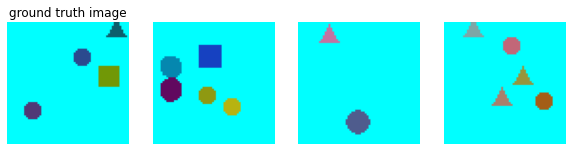

In [12]:
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(gt_image[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title('ground truth image')

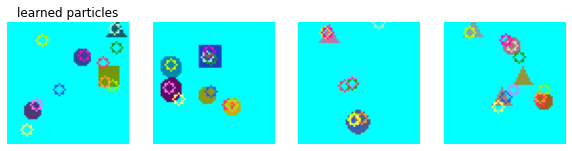

In [13]:
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(img_with_posterior_kp[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title('learned particles')

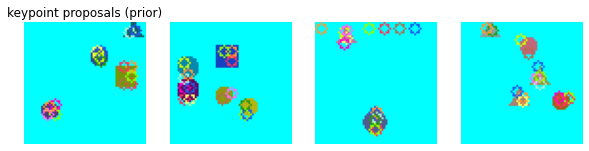

In [15]:
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(img_with_kp_proposals[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title('keypoint proposals (prior)')

In [17]:
# top-k
with torch.no_grad():
    logvar_sum = logvar[:, :-1].sum(-1)
    logvar_topk = torch.topk(logvar_sum, k=topk, dim=-1, largest=False)
    indices = logvar_topk[1]  # [batch_size, topk]
    batch_indices = torch.arange(mu.shape[0]).view(-1, 1).to(mu.device)
    topk_kp = mu[batch_indices, indices]
    img_with_kp_topk = plot_keypoints_on_image_batch(topk_kp.clamp(min=kp_range[0], max=kp_range[1]), x,
                                                         radius=3, thickness=1, max_imgs=max_imgs,
                                                         kp_range=kp_range)
    img_with_topk_kp = img_with_kp_topk[:num_images, -3:].permute(0, 2, 3, 1).data.cpu().numpy()

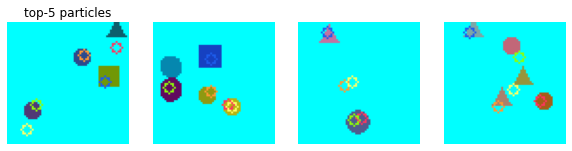

In [18]:
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(img_with_topk_kp[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title(f'top-{topk} particles')

In [23]:
# bounding boxes
with torch.no_grad():
    masks = create_masks_fast(mu[:, :-1].detach(), anchor_s=model.anchor_s, feature_dim=x.shape[-1])
    masks = torch.where(masks < mask_threshold, 0.0, 1.0)
    img_with_masks_nms, nms_ind = plot_bb_on_image_batch_from_masks_nms(masks, x, scores=bb_scores,
                                                                        iou_thresh=iou_thresh,
                                                                        thickness=1, max_imgs=max_imgs,
                                                                        hard_thresh=hard_threshold)
    img_with_bb = img_with_masks_nms[:num_images, -3:].permute(0, 2, 3, 1).data.cpu().numpy()

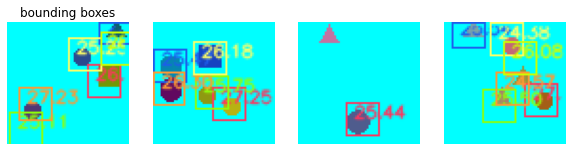

In [24]:
# this can be further improved with smarter thresholding and learning the scale of the boxes
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(img_with_bb[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title(f'bounding boxes')

In [27]:
# reconstruction and generated objects
reconsturction = rec_x[:num_images, -3:].permute(0, 2, 3, 1).data.cpu().numpy().clip(0, 1)
all_objects_with_masks = dec_objects[:num_images, -3:].permute(0, 2, 3, 1).data.cpu().numpy().clip(0, 1)

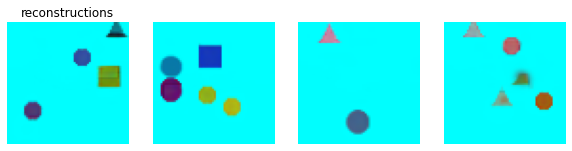

In [28]:
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(reconsturction[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title(f'reconstructions')

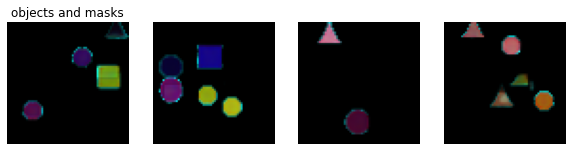

In [29]:
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(all_objects_with_masks[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title(f'objects and masks')

In [32]:
# manipulation - let's move the particles a bit and see what happens
mu_manip = mu + 0.3
with torch.no_grad():
    rec_new, _, _ = model.decode_all(mu_manip, mu_features, kp_heatmap=None, obj_on=obj_on, deterministic=True)
    rec_new = rec_new.clamp(0, 1)
    manip_reconstruction = rec_new[:num_images, -3:].permute(0, 2, 3, 1).data.cpu().numpy().clip(0, 1)

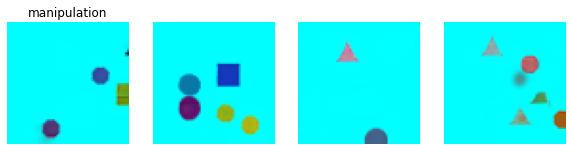

In [33]:
fig = plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i + 1)
    ax.imshow(manip_reconstruction[i])
    ax.set_axis_off()
    if i == 0:
        ax.set_title(f'manipulation')

### <img src="https://img.icons8.com/doodle/96/000000/where-to-quest.png" style="height:50px;display:inline">  Where to Next?
---
There is a lot of room for improvement:
* Try to replace the MSE reconstruction loss with perceptual (VGG) loss.
* Try to manipulate the features of each particle as well.
* Architecture-wise: try replacing BatchNorm with GroupNorm, maybe other components will work better.
* Hyper-parameters: try playing with the `beta_kl` and `kl_balance`.
* What is the effect of the learned features dimensions?

We think DLP is a super interesting framework, results can be pushed even further with more engineering!

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com